## Deep Learning Black-Scholes Formula - III

In [204]:
import numpy as np
import torch
import csv
import matplotlib.pyplot as plt

In [205]:
dataset = []
with open('../data/black_scholes_with_greeks.csv', newline='\n') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    dataset.append(row)

train_set, test_set = np.array(dataset[:30000], dtype=float), np.array(dataset[30000:], dtype=float)
train_features, train_labels = torch.from_numpy(train_set[:, 0:5]), torch.from_numpy(train_set[:, 5:])
test_features, test_labels = torch.from_numpy(test_set[:, 0:5]), torch.from_numpy(test_set[:, 5:])

In [207]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features, train_labels),
                                         batch_size,
                                         shuffle=True)
test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_features, test_labels),
                                        batch_size,
                                        shuffle=False)


In [208]:
num_inputs = 5
num_hidden = 100
num_outputs = 1

w1 = torch.nn.Parameter(torch.randn(num_inputs, num_hidden, requires_grad=True) * .02)
b1 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w2 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .01)
b2 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w3 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .03)
b3 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w4 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .01)
b4 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w5 = torch.nn.Parameter(torch.randn(num_hidden, num_outputs, requires_grad=True) * .05)
b5 = torch.nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [w1, b1, w2, b2, w3, b3, w4, b4, w5, b5]

class Model(torch.nn.Module):
  def __init__(self, params) -> None:
    super(Model, self).__init__()
    self.softplus = torch.nn.Softplus()
    self.sigmoid = torch.nn.Sigmoid()
    self.w1 = params[0]
    self.b1 = params[1]
    self.w2 = params[2]
    self.b2 = params[3]
    self.w3 = params[4]
    self.b3 = params[5]
    self.w4 = params[6]
    self.b4 = params[7]
    self.w5 = params[8]
    self.b5 = params[9]

  def forward(self, x):
    y1 = self.softplus(torch.matmul(x,  self.w1) + self.b1)
    y2 = self.softplus(torch.matmul(y1, self.w2) + self.b2)
    y3 = self.softplus(torch.matmul(y2, self.w3) + self.b3)
    y4 = self.softplus(torch.matmul(y3, self.w4) + self.b4)
    out = torch.matmul(y4, self.w5) + self.b5

    deriv = torch.ones_like(out)
    deriv = torch.matmul(deriv, torch.transpose(self.w5, 0, 1)) * self.sigmoid(y4)
    deriv = torch.matmul(deriv, torch.transpose(self.w4, 0, 1)) * self.sigmoid(y3)
    deriv = torch.matmul(deriv, torch.transpose(self.w3, 0, 1)) * self.sigmoid(y2)
    deriv = torch.matmul(deriv, torch.transpose(self.w2, 0, 1)) * self.sigmoid(y1)
    deriv = torch.matmul(deriv, torch.transpose(self.w1, 0, 1)) * self.sigmoid(x)

    return out, deriv

model = Model(params)

In [209]:
loss = torch.nn.MSELoss()

In [217]:
learning_rate = 0.0001
optimizer = torch.optim.SGD(params, lr=learning_rate)

In [218]:
num_epochs = 30
for epoch in range(num_epochs):
  for X, y in train_iter:
    val, deriv = model(X.float())
    l1 = loss(val, y.float()[:, 0].reshape(val.shape))
    l2 = loss(deriv, y.float()[:, 1:].reshape(deriv.shape))
    l = l1 + l2

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

  val, deriv = model(train_features.float())
  l1 = loss(val, train_labels.float()[:, 0].reshape(val.shape))
  l2 = loss(deriv, train_labels.float()[:, 1:].reshape(deriv.shape))
  l = l1 + l2
  print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.069280
epoch 2, loss 0.070158
epoch 3, loss 0.070357
epoch 4, loss 0.069176
epoch 5, loss 0.069740
epoch 6, loss 0.068952
epoch 7, loss 0.069646
epoch 8, loss 0.071163
epoch 9, loss 0.069795
epoch 10, loss 0.069380
epoch 11, loss 0.068451
epoch 12, loss 0.068281
epoch 13, loss 0.071266
epoch 14, loss 0.068201
epoch 15, loss 0.069274
epoch 16, loss 0.068052
epoch 17, loss 0.068961
epoch 18, loss 0.068018
epoch 19, loss 0.067848
epoch 20, loss 0.068478
epoch 21, loss 0.067787
epoch 22, loss 0.067744
epoch 23, loss 0.067838
epoch 24, loss 0.067565
epoch 25, loss 0.067948
epoch 26, loss 0.069116
epoch 27, loss 0.069583
epoch 28, loss 0.067928
epoch 29, loss 0.079298
epoch 30, loss 0.067765


In [222]:
torch.save(model.state_dict(), '../save/black_scholes_iii.ckpt')

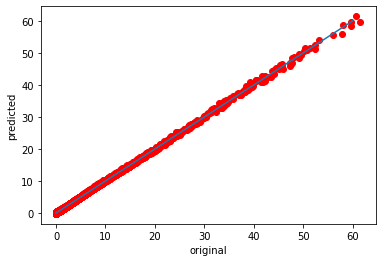

In [220]:
with torch.no_grad():
  val, deriv = model(train_features.float())
  predicted = val.numpy().reshape(-1)
  original = train_labels[:, 0].numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 60], [0, 60])
  plt.show()

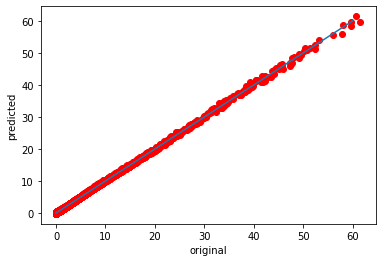

In [221]:
with torch.no_grad():
  val, deriv = model(train_features.float())
  predicted = val.numpy().reshape(-1)
  original = train_labels[:, 0].numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 60], [0, 60])
  plt.show()

In [22]:
from synthetic_black_scholes_data import value_call_option
import random

strike = random.uniform(7, 650)
spot = random.uniform(10, 500)
maturity = random.randint(1, 1095) / 365.
dividend = random.uniform(.0,  .03)
discount = random.uniform(.01, .03)
volatility = random.uniform(.05, .9)

price = value_call_option(strike, spot, maturity, dividend, discount, volatility) / strike
predicted = model(torch.tensor([spot / strike, maturity, dividend, discount, volatility])).detach()
print(price)
print(predicted)

0.5008855378998333
tensor([0.4817])
